In [2]:
#HW 07: phase retrieval
# Starter code by Jesse Wilson (2024) jesse.wilson@colostate.edu
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision.transforms.functional import gaussian_blur
import numpy as np
from random import randint

device=torch.device('cuda:0')

In [3]:
# use this for newer versions of Pytorch
from torch.fft import fft2, fftshift, ifft2, ifftshift

torch.Size([1, 64, 64])


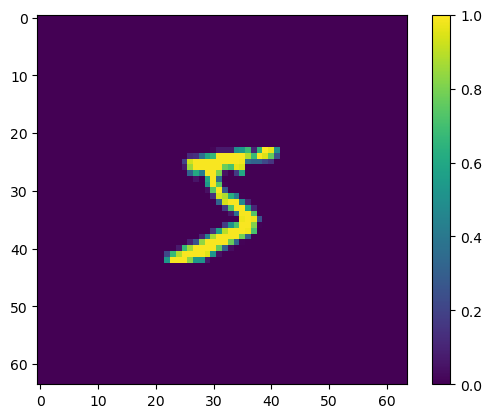

In [4]:
# load the usual suspects
batch_size=64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(18)])
dataset_train = datasets.MNIST(root='data',train=True,download=True,transform=transform)
dataset_val = datasets.MNIST(root='data',train=False,download=True, transform = transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=64)


print(dataset_train[0][0].shape)
plt.imshow(dataset_train[0][0].squeeze())
plt.colorbar()
plt.show()



In [5]:
def createAperture( radius ):
    x=np.linspace(1,64,64)-32
    y=np.linspace(1,64,64)-32
    X,Y = np.meshgrid(x,y)
    
    aperture = X**2+Y**2 <= radius**2
    return aperture

def createPhaseObject( img, aperture ):
    # set up a complex object in which the image is encoded with phase
    # and is surrounded by an opaque aperture
    nbatch = img.shape[0]
    obj = torch.exp( 3.14j/18.*img )
    obj = obj * aperture

    return obj


In [6]:
def forwardModel( obj ):
    # calculate a diffraction patern of a complex object using the Fourier transform
    diffr_complex = fftshift(fft2(ifftshift(obj)))
    
    diffr_phase = diffr_complex.angle() # phase of diffraction patern (not measurable)
    diffr_abs = diffr_complex.abs()   # amplitude of diffraction pattern (seen by imaging sensor)

    return( diffr_abs, diffr_phase )

In [96]:
# 64x64 encoder decoder network
# uses strided convs instead of conv->maxpool
# uses strided transposed convs instead of upsampling -> conv

nFilt = 32
enc = nn.Sequential(
    nn.Conv2d(1,nFilt,kernel_size=3,stride=2), # 64x64 -> 31x31
    nn.LeakyReLU(),
    nn.Conv2d(nFilt,nFilt,kernel_size=3,stride=2), # 31x31 -> 15x15
    nn.LeakyReLU(),
    nn.Conv2d(nFilt,nFilt,kernel_size=3,stride=2), # 15x15 -> 7x7
    nn.LeakyReLU(),
    nn.Conv2d(nFilt,nFilt,kernel_size=3,stride=2), # 7x7 -> 3x3
    nn.LeakyReLU()
)

dec = nn.Sequential(
    nn.ConvTranspose2d(nFilt,nFilt,kernel_size=3,stride=2), # 3x3 -> 7x7
    nn.LeakyReLU(),
    nn.ConvTranspose2d(nFilt,nFilt,kernel_size=3,stride=2), # 7x7 -> 15x15
    nn.LeakyReLU(),
    nn.ConvTranspose2d(nFilt,nFilt,kernel_size=3,stride=2), # 15x15 -> 31x31
    nn.LeakyReLU(),
    nn.ConvTranspose2d(nFilt,1,kernel_size=3,stride=2,output_padding=1), # 15x15 -> 64x64
)

net = nn.Sequential(enc,dec).to(device)
for m in net.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
        nn.init.constant_(m.bias,0)

In [161]:
# 64x64 encoder decoder network with fully connected bottleneck
# uses strided convs instead of conv->maxpool
# uses strided transposed convs instead of upsampling -> conv
# note: started modifying my previous code for encoder-decoder, got stuck on 
#       exact syntax and details for flattening/unflattening, so the initial
#       draft of the bottleneck was generated by prompting MS Copilot:
#       
#       Simple pytorch code for encoder-decoder with a fully-connected bottleneck. 
#       Should take 64x64 images, use strided convolutions for downsampling 
#       and transposed convs for upsampling, and have a 7x7 bottleneck.
#
class EncDec( nn.Module ):
    def __init__(self):
        super().__init__()
        self.nFilt = 32
        self.enc = nn.Sequential(
            nn.Conv2d(1,self.nFilt,kernel_size=3,stride=2), # 64x64 -> 31x31
            nn.LeakyReLU(),
            nn.Conv2d(self.nFilt,self.nFilt,kernel_size=3,stride=2), # 31x31 -> 15x15
            nn.LeakyReLU(),
            nn.Conv2d(self.nFilt,self.nFilt,kernel_size=3,stride=2), # 15x15 -> 7x7
            nn.LeakyReLU(),
            nn.Conv2d(self.nFilt,self.nFilt,kernel_size=3,stride=2), # 7x7 -> 3x3
            nn.LeakyReLU()
        )

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(self.nFilt,self.nFilt,kernel_size=3,stride=2), # 3x3 -> 7x7
            nn.LeakyReLU(),
            nn.ConvTranspose2d(self.nFilt,self.nFilt,kernel_size=3,stride=2), # 7x7 -> 15x15
            nn.LeakyReLU(),
            nn.ConvTranspose2d(self.nFilt,self.nFilt,kernel_size=3,stride=2), # 15x15 -> 31x31
            nn.LeakyReLU(),
            nn.ConvTranspose2d(self.nFilt,1,kernel_size=3,stride=2,output_padding=1), # 15x15 -> 64x64
        )

        self.bottleneck = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(3*3*self.nFilt, 3*3*self.nFilt),
            nn.LeakyReLU(),
            nn.Linear(3*3*self.nFilt, 3*3*self.nFilt),
            nn.LeakyReLU(),
            nn.Unflatten(1,(self.nFilt,3,3))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                nn.init.constant_(m.bias,0)

    def forward(self,x):
        x = self.enc(x)
        x = self.bottleneck(x)
        x = self.dec(x)

        return x

net = EncDec().to(device)

In [153]:
# define a simple u-net
class UNet( nn.Module ):
    def __init__(self):
        super().__init__()
        
        self.downconv1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))
        self.downconv2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))
        self.downconv3 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))
        self.downconv4 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))

        self.upconv1 = nn.Sequential(
                    nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                    nn.BatchNorm2d(32) )
        self.upconv2 = nn.Sequential(
                    nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                    nn.BatchNorm2d(32) )
        self.upconv3 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                        nn.BatchNorm2d(32) )
        self.upconv4 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                        nn.BatchNorm2d(32) )

        self.outconv = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 3, padding=1)

    def forward(self, x):
        featdown1 = F.leaky_relu(self.downconv1(x))
        featdown2 = F.leaky_relu(self.downconv2(F.max_pool2d(featdown1,2)))
        featdown3 = F.leaky_relu(self.downconv3(F.max_pool2d(featdown2,2)))
        featdown4 = F.leaky_relu(self.downconv4(F.max_pool2d(featdown3,2)))

        featup1 = F.leaky_relu(self.upconv1(F.max_pool2d(featdown4,2)))
        skip1 = torch.cat((featdown4, featup1),1)
        featup2 = F.leaky_relu(self.upconv2(skip1))
        skip2 = torch.cat((featdown3, featup2),1)
        featup3 = F.leaky_relu(self.upconv3(skip2))
        skip3 = torch.cat((featdown2, featup3),1)
        featup4 = F.leaky_relu(self.upconv4(skip3))
        skip4 = torch.cat((featdown1, featup4),1)
        out = self.outconv(skip4)
        
        return out
        
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.)

net = UNet().to(device)
net.apply(init_weights)

UNet(
  (downconv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downconv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downconv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downconv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upconv1): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [79]:
# define a simple u-net with resampling
class UNet( nn.Module ):
    def __init__(self):
        super().__init__()
        
        self.downconv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding=1) # 64x64
        self.downconv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1) # 32x32
        self.downconv3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1) # 16x16
        self.downconv4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1) # 8x8

        self.upconv1 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1) # 4x4
        self.upconv2 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1) # 8x8
        self.upconv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1) # 16x16
        self.upconv4 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1) # 32x32

        self.outconv = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 3, padding=1, bias=False) # 64x64

        # initialize weights
        for m in self.modules():
            if isinstance(m,nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                torch.nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.)     

    def forward(self, x):
        featdown1 = F.leaky_relu(self.downconv1(x)) # 64x64
        featdown2 = F.leaky_relu(self.downconv2(F.avg_pool2d(featdown1,2))) # 32x32
        featdown3 = F.leaky_relu(self.downconv3(F.avg_pool2d(featdown2,2))) # 16x16
        featdown4 = F.leaky_relu(self.downconv4(F.avg_pool2d(featdown3,2))) # 8x8

        featup1 = F.interpolate(F.leaky_relu(self.upconv1(F.avg_pool2d(featdown4,2))),scale_factor=2,mode='bilinear') # 8x8
        skip1 = torch.cat((featdown4, featup1),1) # 8x8
        featup2 = F.interpolate(F.leaky_relu(self.upconv2(skip1)), scale_factor=2,mode='bilinear') # 16x16
        skip2 = torch.cat((featdown3, featup2),1) # 16x16
        featup3 = F.interpolate(F.leaky_relu(self.upconv3(skip2)), scale_factor=2, mode='bilinear') # 32x32
        skip3 = torch.cat((featdown2, featup3),1) # 32x32
        featup4 = F.interpolate(F.leaky_relu(self.upconv4(skip3)), scale_factor=2, mode='bilinear') # 64x64
        skip4 = torch.cat((featdown1, featup4),1) # 64x64
        out = self.outconv(skip4) # 64x64
        
        return out

net = UNet().to(device)

In [87]:
diffr_abs.shape

torch.Size([64, 64])

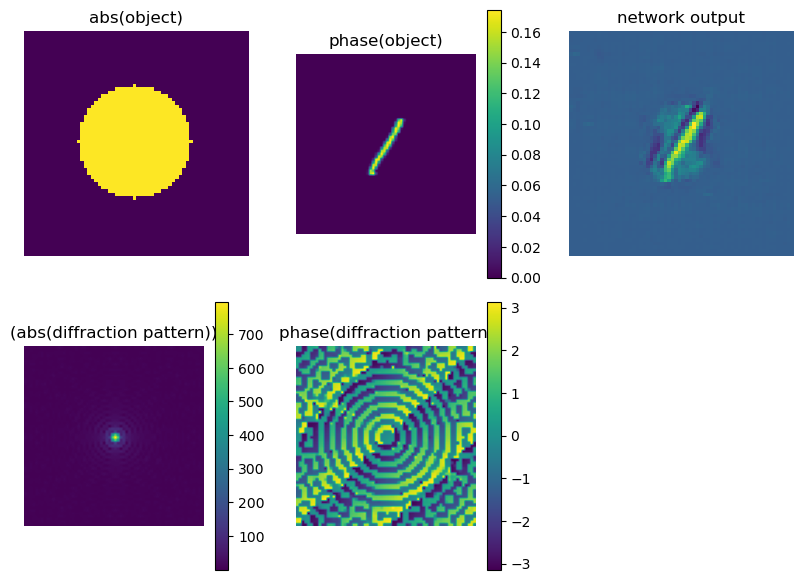

In [86]:
# quick test: generate a random object, diffraction pattern, and pass through network
ind = randint(0,len(dataset_val)-1)
img = dataset_val[ind][0].to(device).unsqueeze(0)

aperture = createAperture(16)
aperture = torch.Tensor(aperture).to(device)

obj_complex = createPhaseObject(img, aperture)
diffr_abs, diffr_phase  = forwardModel(obj_complex)

obj_phase_est = net(diffr_abs)

# plot the results
plt.figure(figsize=(8,6))

plt.subplot(231)
plt.imshow(obj_complex.abs().cpu().squeeze())
plt.axis('off')
plt.title('abs(object)')

plt.subplot(232)
plt.imshow(obj_complex.angle().cpu().squeeze())
plt.axis('off')
plt.colorbar()
plt.title('phase(object)')

plt.subplot(233)
plt.imshow(obj_phase_est.detach().cpu().squeeze())
plt.axis('off')
plt.title('network output')

plt.subplot(234)
plt.imshow((diffr_abs.cpu().squeeze()))
plt.colorbar()
plt.axis('off')
plt.title('(abs(diffraction pattern))')

plt.subplot(235)
plt.imshow(diffr_phase.cpu().squeeze())
plt.colorbar()
plt.axis('off')
plt.title('phase(diffraction pattern)')

plt.tight_layout()
plt.show()

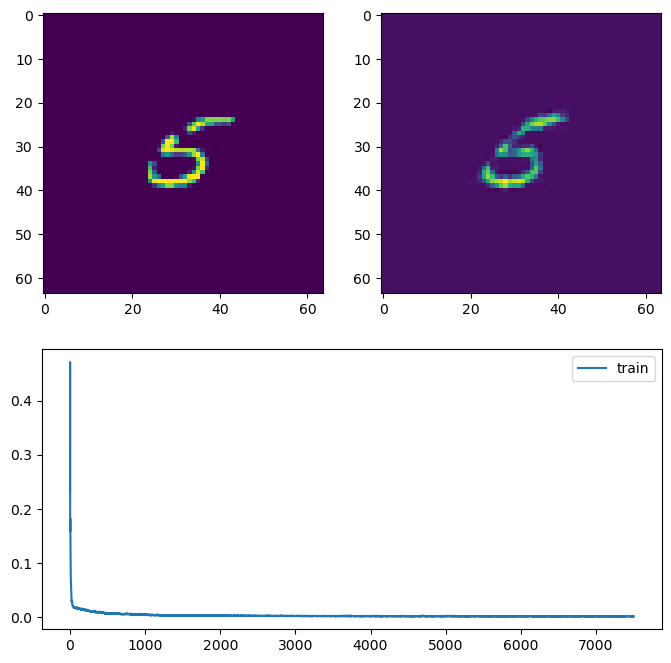

KeyboardInterrupt: 

In [163]:
# APPROACH 1: directly estimate object's phase (real space)
#net = nn.Sequential(enc,dec).to(device) # reset the network
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
loss_fn = nn.L1Loss()

# load a limited set of the training data onto the GPU
nTrain = 5000
#y = dataset_train.data.unsqueeze(1).float().to(device)
#y= y[0:nTrain]
#y = dataset_train[0:nTrain]

# calculate complex objects
aperture = createAperture(16)
aperture = torch.Tensor(aperture).to(device)


# load entire validation set onto the GPU
#y_val = dataset_val.data.unsqueeze(1).float().to(device)
#y_val = y_val[0:nTrain]
#obj_val = createPhaseObject( y_val, aperture )
#diffr_abs_val, diffr_phase_val = forwardModel(obj_val)

loss_train_vec = []
#loss_val_vec = []

# training loop
n_epochs = 1500
for epoch in range(1,n_epochs):
    for img, label in dataloader_train:
        img = img.to(device)
        obj = createPhaseObject( img, aperture )
        diffr_abs, diffr_phase = forwardModel(obj)

        obj_phase_est = net(diffr_abs)
    
        loss = loss_fn(obj_phase_est,obj.angle())
        optimizer.zero_grad()
     
        loss.backward()
        optimizer.step()
    
        loss_train_vec += [loss.item()]
        
    # calculate validation loss
    #with torch.no_grad():
    #    obj_phase_est_val = net(diffr_abs_val)
    #    loss_val = loss_fn(obj_phase_est_val, obj_val.angle())
    #    
    #loss_val_vec   += [loss_val.item()]
    
    # plot training/validation loss curves
    clear_output(wait=True)
    plt.figure(figsize=[8,8])
    plt.subplot(221)
    plt.imshow(obj[0].angle().cpu().squeeze())
    plt.subplot(222)
    plt.imshow(obj_phase_est[0].detach().cpu().squeeze())
    plt.subplot(212)
    plt.plot(loss_train_vec)
    #plt.plot(loss_val_vec)
    plt.legend(['train','val'])
    plt.show()
    

In [261]:
class GradientMagnitude(nn.Module):
    def __init__(self,dev):
        super().__init__()
        self.sobel_x = torch.tensor([[1.,0.,-1.],[2.,0.,-2.],[1.,0.,1.]]).unsqueeze(0).unsqueeze(0).to(dev)
        self.sobel_y = torch.tensor([[1.,2.,1.],[0.,0.,0.],[-1.,-2.,-1.]]).unsqueeze(0).unsqueeze(0).to(dev)

    def forward(self, x):
        # calculate summed magnitude of the gradients of an image
        grad_x = F.conv2d(x,self.sobel_x)
        grad_y = F.conv2d(y,self.sobel_y)
    
        absgrad = -torch.abs(grad_x)**2 + torch.abs(grad_y)**2
        return torch.mean(absgrad)

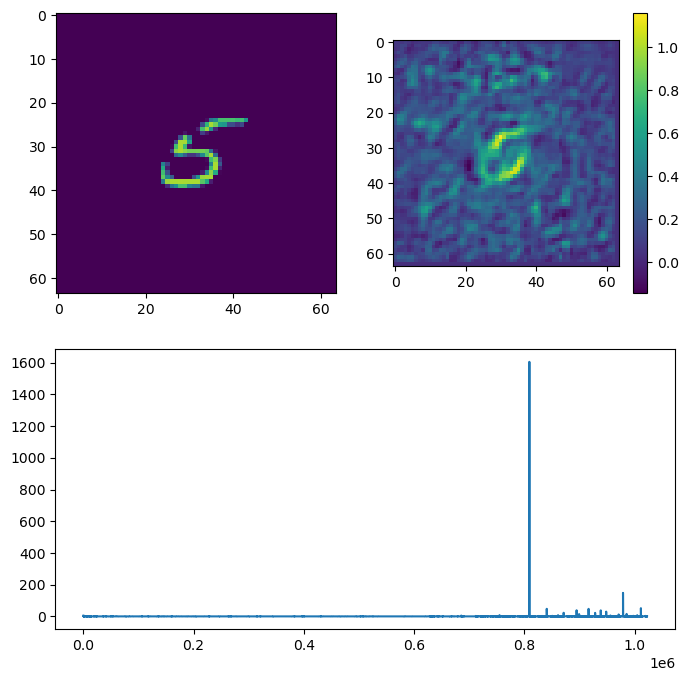

KeyboardInterrupt: 

In [98]:
# unsupervised training
# given measured diffraction amplitude pattern, find object phase such that estimated diffraction pattern matches measured

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
#loss_fn_gradmag = GradientMagnitude(device)


# calculate complex objects
aperture = createAperture(16)
aperture = torch.Tensor(aperture).to(device)

# load entire validation set onto the GPU
#y_val = dataset_val.data.unsqueeze(1).float().to(device)/255.
#y_val = y_val[0:nTrain]
#obj_val = createPhaseObject( y_val, aperture )
#diffr_abs_val, diffr_phase_val = forwardModel(obj_val)

loss_train_vec = []
#loss_val_vec = []

# training loop
n_epochs = 1500
for epoch in range(1,n_epochs):
    for img, label in dataloader_train:
        img = img.to(device)
        obj = createPhaseObject( img, aperture )
        diffr_abs, diffr_phase = forwardModel(obj)

        obj_phase_est = net(diffr_abs)
        
        obj_est = createPhaseObject(obj_phase_est, aperture)
        diffr_abs_est, diffr_phase_est = forwardModel(obj_est)

        # unsupervised loss (does NOT make use of object phase)
        #loss = loss_fn(diffr_abs_est,diffr_abs) + 0.1*torch.mean(torch.abs(obj_phase_est*(1-aperture))) + 0.1*torch.mean(torch.relu(-1*obj_phase_est))+0.001*loss_fn_gradmag(obj_phase_est)
        #loss = loss_fn(diffr_abs_est,diffr_abs) + 0.00001*loss_fn_gradmag(obj_phase_est)
        loss  = loss_fn(diffr_abs_est,diffr_abs) + 0.1*torch.mean(obj_phase_est**2) + torch.mean(torch.relu(-1*obj_phase_est))
        optimizer.zero_grad()
    
        loss.backward()
        optimizer.step()
        #scheduler.step(loss)
    
        loss_train_vec += [loss.item()]
    
 
    # plot training/validation loss curves
    clear_output(wait=True)
    plt.figure(figsize=[8,8])
    plt.subplot(221)
    plt.imshow(obj[0].angle().cpu().squeeze(),vmin=0,vmax=0.2)
    plt.subplot(222)
    plt.imshow(obj_phase_est[0].detach().cpu().squeeze())
    plt.colorbar()
    plt.subplot(212)
    plt.plot(loss_train_vec)
    plt.show()
    


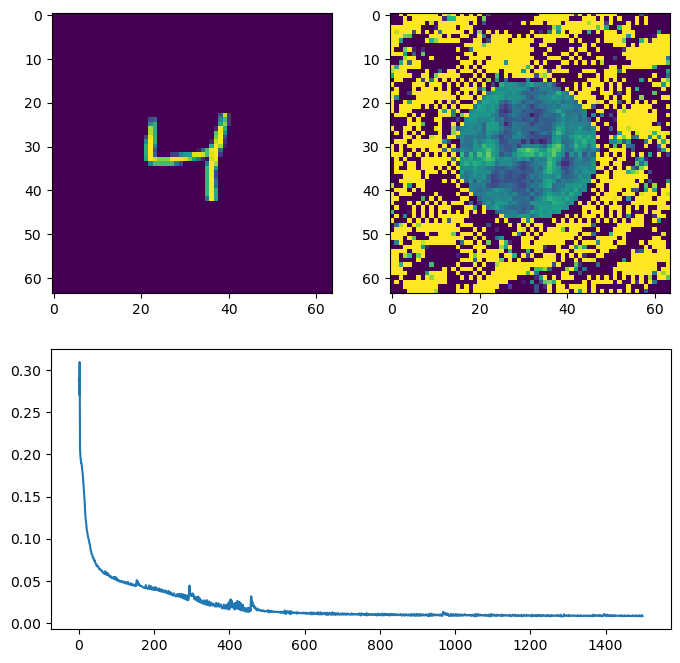

In [62]:
y = dataset_train.data.unsqueeze(1).float().to(device)/255.
y= y[2]
obj = createPhaseObject( y, aperture )
diffr_abs, diffr_phase = forwardModel(obj)
with torch.no_grad():
    diffr_phase_est = net(diffr_abs)

diffr_est=diffr_abs*torch.complex( torch.cos(diffr_phase_est) , torch.sin(diffr_phase_est) )
obj_est = fftshift(ifft2(ifftshift(diffr_est)))
obj_phase_est = obj_est.angle()



plt.figure(figsize=[8,8])
plt.subplot(221)
plt.imshow(obj[0].angle().cpu().squeeze())
plt.subplot(222)
plt.imshow(obj_phase_est[0].detach().cpu().squeeze(),vmin=-0.2,vmax=0.25)
plt.subplot(212)
plt.plot(loss_train_vec)
plt.show()


# Gerchberg-Saxton demo
Select a pair of random numbers; use one for amplitude, the other for phase.